# Welter



Monday, January 4, 2016

## An experiment to add starspot models

part 2

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## Just plot the *flux-calibrated* models
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
import pandas as pd

In [4]:
import Starfish
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha as PHOENIX
import numpy as np
mygrid = PHOENIX(norm=False, base='/Users/gully/GitHub/Starfish/libraries/raw/PHOENIX/')

Hot star

In [5]:
p_A = np.array([4100, 3.5, 0.0])
flux_A, hdr_A = mygrid.load_flux(p_A)

Cool star

In [7]:
p_B = np.array([2800, 3.5, 0.0])
flux_B, hdr_B = mygrid.load_flux(p_B)

(4000, 25000)

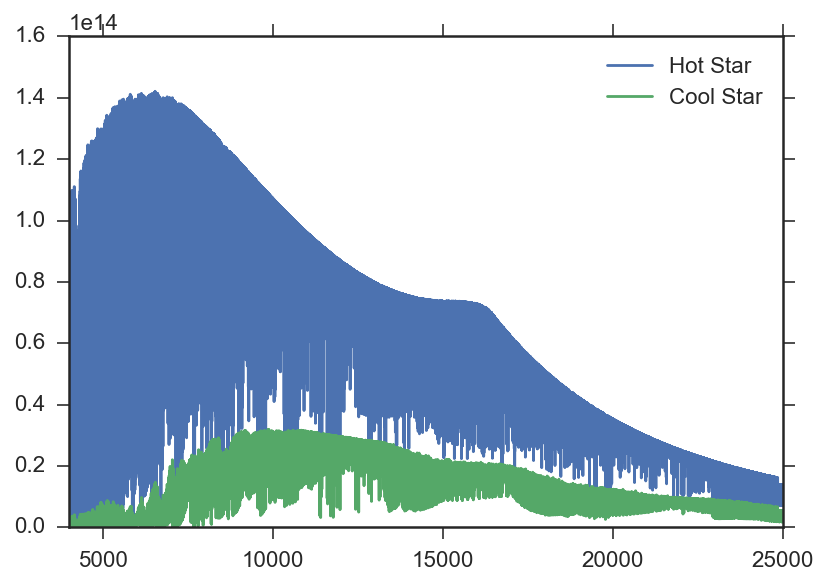

In [8]:
plt.plot(mygrid.wl, flux_A, label='Hot Star')
plt.plot(mygrid.wl, flux_B, label='Cool Star')
plt.legend(loc='best')
plt.xlim(4000, 25000)

Over plot a black body

In [9]:
from astropy import units as u
from astropy.analytic_functions import blackbody_lambda, blackbody_nu

The flux units are: `erg/s/cm2/cm`

In [11]:
wavelengths = mygrid.wl * u.AA
with np.errstate(all='ignore'):
    bb_A_raw = blackbody_lambda(wavelengths, 4100 * u.K)
    bb_B_raw = blackbody_lambda(wavelengths, 2800 * u.K)

bb_A = bb_A_raw.to(u.erg/(u.s*(u.cm**2)*u.cm*u.sr))
bb_B = bb_B_raw.to(u.erg/(u.s*(u.cm**2)*u.cm*u.sr))

In [12]:
rat = flux_B/flux_A
bb_rat = bb_B/bb_A

In [13]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [14]:
n=400
sm_rat = moving_average(rat, n=n) #Smoothed ratio
srr = sm_rat[::n]
rwl = mygrid.wl[:-n:n]
bb_rat = bb_rat[:-n:n]

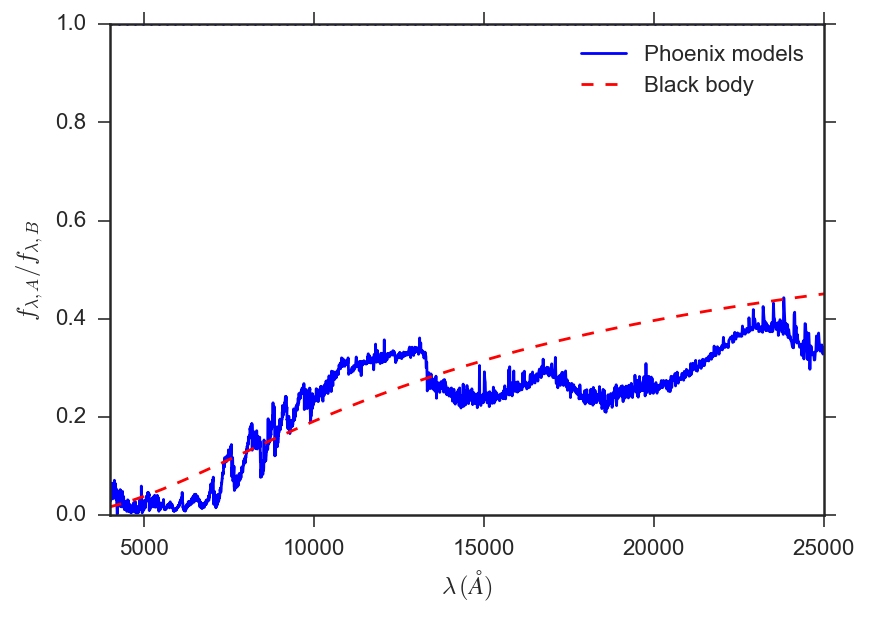

In [15]:
plt.plot(rwl, srr, 'b-', label = 'Phoenix models')
#plt.plot(mygrid.wl, rat, 'k.', alpha=0.002)

plt.plot(rwl, bb_rat, 'r--', label='Black body')
plt.plot([4000, 25000], [1.0, 1.0], 'b:')
plt.xlim(4000, 25000)
plt.ylim(0.0, 1.0)
plt.xlabel('$\lambda \, (\AA)$')
plt.ylabel('$f_{\lambda, A} / f_{\lambda, B}$')
plt.legend(loc='best')

Save the data to be overplotted elsewhere.

In [16]:
srr

array([ 0.00538946,  0.00907415,  0.01566093, ...,  0.54831251,
        0.54336263,  0.54466914])

In [17]:
rat_out = pd.DataFrame({"wavelength":rwl, "ratio":srr})
bb_out = pd.DataFrame({"wavelength":rwl, "ratio":bb_rat})

In [18]:
bb_out.to_csv('../data/analysis/rat_BB_2800_4100.csv', index=False)
rat_out.to_csv('../data/analysis/rat_PHX_2800_4100.csv', index=False)

Let's assume we have 20% of the star covered in spots.

In [19]:
f=0.50

In [20]:
mixture_model = f * flux_A + (1 - f) * flux_B

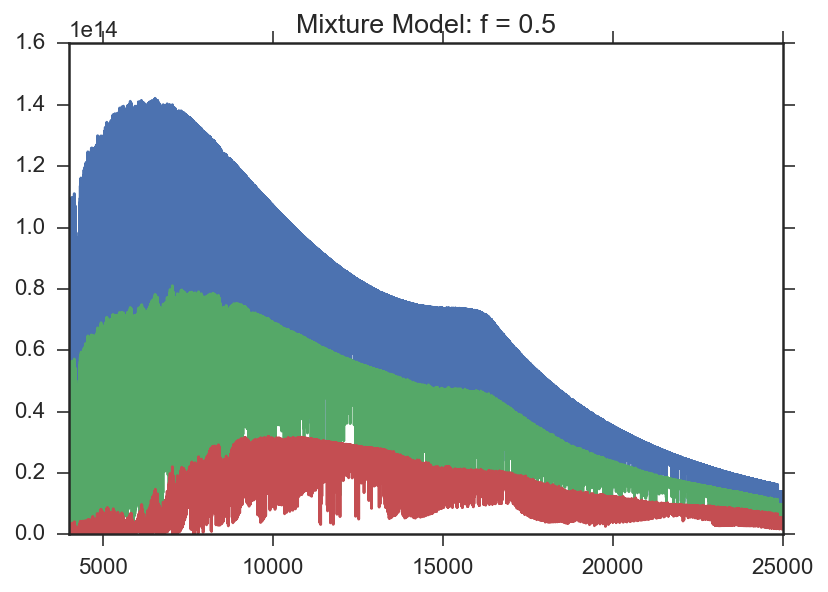

In [21]:
plt.plot(mygrid.wl, flux_A, label='Warm star')
plt.plot(mygrid.wl, mixture_model, label='Mixture model')
plt.plot(mygrid.wl, flux_B, label='Cool star')
plt.xlim(4000, 25000)
plt.title('Mixture Model: f = {}'.format(f));

## Calculate flux ratio to manually undo normalization

From line 256 of `grid_tools.py`

In [14]:
from scipy.integrate import trapz

In [15]:
from Starfish import constants as C

In [16]:
wl = mygrid.wl

In [17]:
#convert from erg/cm^2/s/cm to erg/cm^2/s/A
F_bol_A = trapz(flux_A*1e-8, wl)
ratio_A = (C.F_sun / F_bol_A)
f_A_norm = flux_A * ratio_A  #bolometric luminosity is always 1 L_sun

In [18]:
print("The flux ratio is: {}".format(ratio_A))

The flux ratio is: 4.022492223238279


In [19]:
#convert from erg/cm^2/s/cm to erg/cm^2/s/A
F_bol_B = trapz(flux_B*1e-8, wl)
ratio_B = (C.F_sun / F_bol_B)
f_B_norm = flux_B * ratio_B  #bolometric luminosity is always 1 L_sun

In [21]:
print("The flux ratio is: {}".format(ratio_B))

The flux ratio is: 9.649703010839403


How much is $f_B$ scaled by relative to $f_A$?

$F_{B,bol} = \int{f_{B, \lambda}}{d\lambda}$  
$F_{A,bol} = \int{f_{A, \lambda}}{d\lambda}$

In [33]:
print("Star B is {:.5f} times less luminous than Star A.".format(F_bol_A/F_bol_B))

Star B is 2.39894 times less luminous than Star A.


In [32]:
trapz(rat, wl)

0.56915079546802105

The end.